### Exploratory Analysis on Consumer Behavior
#### Author: Qingchuan Lyu
#### Overview
Given the customer, date, and dollar value of orders placed at a store in 2017, as well as the actual gender and predicted gender of each customer, I completed the following exploratory analysis to understand purchasing behavior and consumer backgrounds, such as genders. For each question, I stated any considerations or assumptions in my mind. 

A) Assemble a dataframe with one row per customer and the following columns:

customer_id * gender * most_recent_order_date * order_count (number of orders placed by this customer)

Sort the dataframe by customer_id ascending and display the first 10 rows.

B) Plot the count of orders per week for the store.

C) Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant? Justify your choice of method.

D) Generate a confusion matrix for the gender predictions of customers in this dataset. You should assume that there is only one gender prediction for each customer. What does the confusion matrix tell you about the quality of the predictions?

E) Describe one of your favorite tools or techniques and give a small example of how it's helped you solve a problem. Limit your answer to one paragraph, and please be specific.

##### Note: This notebook is fully tested with no error.

In [28]:
# Import libraries
import pandas as pd #dataframe manipulation
import numpy as np #matrix computation
import os #check and change working directories
from datetime import datetime #convert string to datetime
from scipy import stats #test statistics
from sklearn.metrics import confusion_matrix #confusion matrix
import matplotlib.pyplot as plt #plots

In [29]:
# Read in csv file
csv_file = pd.read_csv (r'/Users/qingchuanlyu/Documents/Application/take home challenge/screening_exercise_orders_v201810.csv')
# Python transfers "date" variable from csv file to be a string column in this dataframe 
# Translate "date" back to be a datetime variable
csv_file['date_time'] = pd.to_datetime(csv_file['date']) 
# Check column names and values
csv_file.head(5)

,customer_id,gender,date,value,predicted_gender,date_time
0,1000,0,2017-01-01 00:11:31,198.5,1,2017-01-01 00:11:31
1,1001,0,2017-01-01 00:29:56,338.0,1,2017-01-01 00:29:56
2,1002,1,2017-01-01 01:30:31,733.0,1,2017-01-01 01:30:31
3,1003,1,2017-01-01 01:34:22,772.0,1,2017-01-01 01:34:22
4,1004,0,2017-01-01 03:11:54,508.0,1,2017-01-01 03:11:54


### Question A
Assemble a dataframe with one row per customer and the following columns:customer_id * gender * most_recent_order_date * order_count (number of orders placed by this customer). Sort the dataframe by customer_id ascending and display the first 10 rows.
#### Considerations for Question A
Before querying data, I need to check if each customer has only one unique gender. Adding "gender" as a group key in "groupby" statement will lead to more than one row per customer, if a customer corresponds to multiple genders due to data collection errors.
In practice, a customer might place two orders at the same time, so I count "customer_id" as the number of orders a customer placed.

In [30]:
len(csv_file.groupby(['customer_id']))==len(csv_file.groupby(['customer_id', 'gender']))

True

##### Note1: Group keys are sorted in ascending order by default using the groupby operation, so there’s no need for adding .sort_values() below.
##### Note2: Pandas version must be greater than 0.25 for the syntax of .agg() function to work here.

In [31]:
customer_order_count=csv_file\
                    .groupby(['customer_id', 'gender']) \
                    .agg(most_recent_order_date=('date_time', 'max'), order_count=('customer_id', 'size')) \
                    .reset_index()

customer_order_count.head(10)

,customer_id,gender,most_recent_order_date,order_count
0,1000,0,2017-01-01 00:11:31,1
1,1001,0,2017-01-01 00:29:56,1
2,1002,1,2017-02-19 21:35:31,3
3,1003,1,2017-04-26 02:37:20,4
4,1004,0,2017-01-01 03:11:54,1
5,1005,1,2017-12-16 01:39:27,2
6,1006,1,2017-05-09 15:27:20,3
7,1007,0,2017-01-01 15:59:50,1
8,1008,0,2017-12-17 05:47:48,3
9,1009,1,2017-01-01 19:27:17,1


### Question B
Plot the count of orders per week for the store.

In [32]:
# Calculate which week an order was placed with strftime("%W")
# strftime("%W") uses Monday as the first day of the week. 
# All days in a new year preceding the first Monday are considered to be in week 0
# Range: week 00 -- week 53
csv_file['date_week']= csv_file['date_time'].apply(lambda x: x.strftime("%W"))
# Create a dataset at week level and count the number of orders
orders_weekly = csv_file\
                .groupby(['date_week']) \
                .agg(weekly_order_count=('customer_id', 'size')) \
                .reset_index()

orders_weekly.head(5)

,date_week,weekly_order_count
0,00,14
1,01,180
2,02,264
3,03,405
4,04,233


#### Considerations for Question B
A natural guess of the goal of this research question is to compare the count of orders per week for this store, observe possible trends and search for any extreme values (highest/lowest). Therefore, I use a bar chart to track the changes of weekly order numbers for this store.

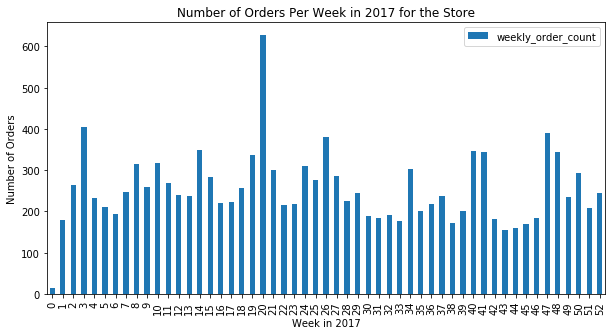

In [33]:
orders_weekly.plot(kind='bar',figsize=(10,5),legend="upper right", xlabel="Week in 2017", ylabel="Number of Orders", title="Number of Orders Per Week in 2017 for the Store")

##### Note: As the above bar chart didn't show a clear trend, I also used the following code to plot a line over the bars. However, this graph is a little messy and confirms the lack of a trend.
>line_chart = df_orders_weekly.plot(kind='line',secondary_y=True, legend = None)

>orders_weekly.plot(kind='bar',figsize=(10,5),legend="upper right", xlabel="Week in 2017", ylabel="Number of Orders", ax = line_chart)

### Question C 
Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant? Justify your choice of method.

In [34]:
# Compute the mean order value for gender 0 and for gender 1
avg_values_gender = csv_file\
                    .groupby(['gender']) \
                    .agg(avg_order_values=('value', 'mean'),count_order=('value', 'size')) \
                    .reset_index()
avg_values_gender

,gender,avg_order_values,count_order
0,0,363.890006,6759
1,1,350.708361,6712


#### Assumptions and Justifications for Question C
To test if the difference between mean order value for gender 0 and for gender 1 is significant, I use a two-sample t test with the following assumptions:
##### Assumption 1: The mean order values of the two populations, customers with gender 0 and gender 1, being compared should follow normal distributions.
##### Justification for Assumption 1: According to the Central Limit Theorem, given a large random sample size (>30) with replacement, the sample mean is approximately normally distributed.
##### Assumption 2: The data used to carry out this test should  be sampled independently from the two populations being compared. 
##### Justification for Assumption 2: By the previous check for Question A, each customer only has one unique gender. Without contexts, I just assume there's no paired(dependent) sample by test designs.
##### Assumption 3: Unequal population variances. 
##### Justification for Assumption 3: In practice, equal population variances of two groups are rare. I let the option "equal_var" be False, and stats.ttest_ind performs a Welch’s t-test, which is insensitive to equality of the variances regardless of whether the sample sizes ('count_order' computed in the previous step) are similar.

In [35]:
stats.ttest_ind(csv_file[csv_file.gender==0].value, csv_file[csv_file.gender==1].value, equal_var=False)

Ttest_indResult(statistic=1.976107933576866, pvalue=0.04816296295128402)

##### Note: As p-value < 0.05 in this test, I reject the null-hypothesis of equal means, and believe the difference between the mean order values for gender 0 and gender 1 is significant.

### Questions D
Generate a confusion matrix for the gender predictions of customers in this dataset. You should assume that there is only one gender prediction for each customer.

In [36]:
# Given the assumption of only one gender prediction for each customer, use max to return the only gender prediction
predicted_genders = csv_file.groupby(['customer_id','gender'], as_index=False)\
                    .agg(pred_gender=('predicted_gender', 'max'))
# Derive arrays for true genders and predicted genders
gender_true = predicted_genders['gender']
gender_predicted = predicted_genders['pred_gender']
# Create confusion matrix
conf_matrix = confusion_matrix(gender_true, gender_predicted, labels=[0,1])
conf_matrix

array([[2189, 2218],
       [ 895, 3512]])

##### Note 1: The rows of this confusion matrix show true genders, and the columns of this confusion matrix show predicted genders.
##### Note 2: By using "labels" option, I make this confusion matrix put gender 0 before gender 1 in rows and columns.

### What does the confusion matrix tell you about the quality of the predictions?
i. False Positive (2218) was more popular than True Negative (2189). That is, when a customer's true gender was 0, it's more likely that this customer's predicted gender was 1.

ii. The Predictions worked much better when a customer's true gender is 1, in which case 3512 out of 4407 (i.e. 895+3512) predictions were correct. This is proved by the recall metric (79.7%) below.

iii. The large amount of False Positive predictions (2218) leads to relatively low precision (61.3%) and accuracy (64.7%).

In [37]:
precision = round(conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1]), 3)
recall = round(conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0]), 3)
accuracy = round((conf_matrix[0,0]+conf_matrix[1,1]) / conf_matrix.sum(), 3)
precision, recall, accuracy

(0.613, 0.797, 0.647)

##### Do I need to look at F1-score in this case?
The accuracy metrix is largely determined by the number of True Positive predictions and True Negative Predictions. However, I care more about False Positive and False Negative predictions, as they lead to business costs. A relatively large amount of False Positive contributes to a relatively low precision metric, as shown above. A relatively small amount of False Negative contributes to a relatively high recall metric, as shown above. Without contexts, I don't really seek balance between precision and recall metrices. The following computation also indicates no imbalanced class distribution: 4407 customers with gender 0 and 4407 customers with gender 1. Therefore, it's not necessary to look at F1-score (harmonic mean of precision and recall).

In [38]:
conf_matrix[0].sum(), conf_matrix[1].sum()

(4407, 4407)

### Question E
Describe one of your favorite tools or techniques and give a small example of how it's helped you solve a problem. Limit your answer to one paragraph, and please be specific.

Answer: My favorite technique is gradient boosting (GBM), because it's simple, impactful and flexible. As part of boosting techniques, gradient boosting is a sequential process, where each sequential model tends to correct the errors of the previous one. The successful later model depends on the previous models. I used Gradient Boosting Decision Tree within the LightGBM framework to predict daily sales for the next 28 days at Walmart. The data covers stores in California/Texas/Wisconsin, and includes product details, prices and holiday special events between 01/2011-06/2018. With Decision Tree as the base learner, subsequent trees were built on errors calculated by the previous tree. Another reasonable choice here was using Random Forest to build independent decision trees, which was known for high accuracy without being overfitting. Comparing the results of these two models for this research question, the gradient boosting technique outperformed Random Forest, and improved prediction accuracy by 14%.